In [7]:
import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


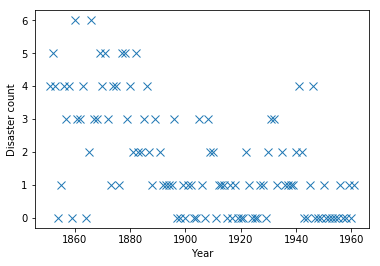

In [6]:
disaster_data = np.ma.masked_values(
                           [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)

years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'x', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [9]:
with pm.Model() as disaster_model:
    
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)
    
    # priors for pre- and post-wsitch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)
    
    # allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)
    

In [10]:
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:14<00:00, 1491.75draws/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24034a90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c24bba0b8>]], dtype=object)

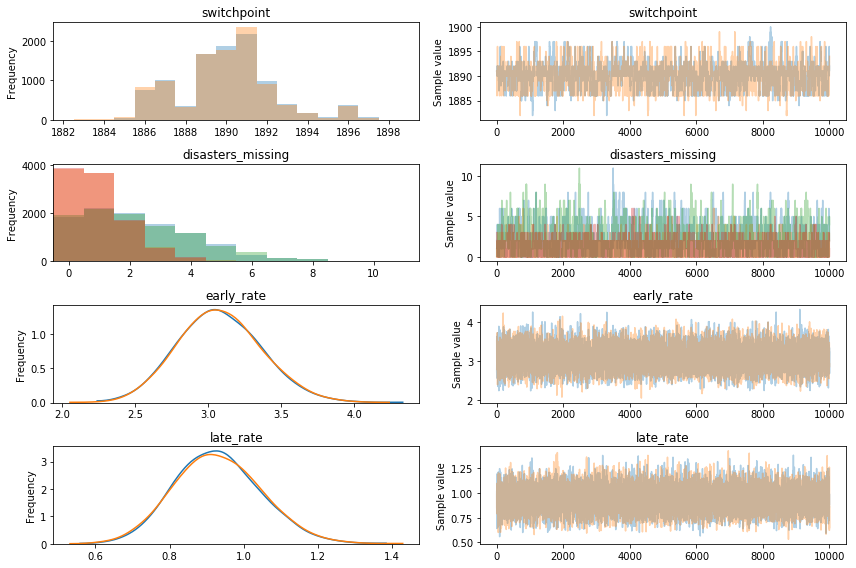

In [11]:
pm.traceplot(trace)

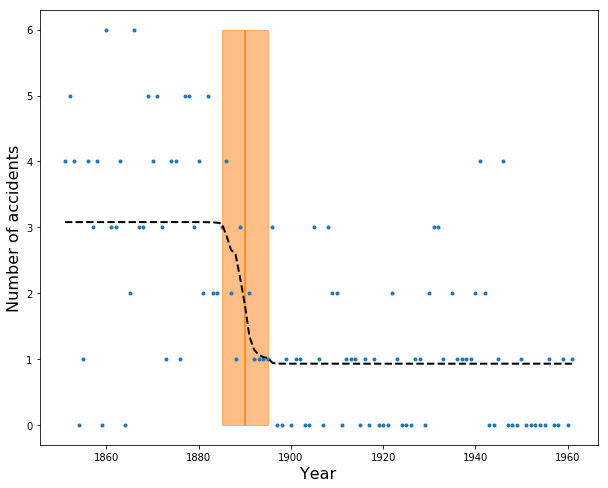

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

### Arbitrary distributions

In [17]:
import theano.tensor as tt

with pm.Model() as model:
    alpha = pm.Uniform('intercept', -100, 100)
    
    # create custom densities
    beta = pm.DensityDist('beta', lambda value: -1.5 * tt.log(1 + value**2), testval=0)
    eps = pm.DensityDist('eps', lambda value: -tt.log(tt.abs_(value)), testval=1)
    
    # create likelihood
    like = pm.Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)

NameError: name 'X' is not defined

### Generalized linear models

In [16]:
import pandas as pd
from pymc3 import GLM

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

df = pd.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

In [18]:
with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x2, x1, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 983.40draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25014400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c250d5b70>]], dtype=object)

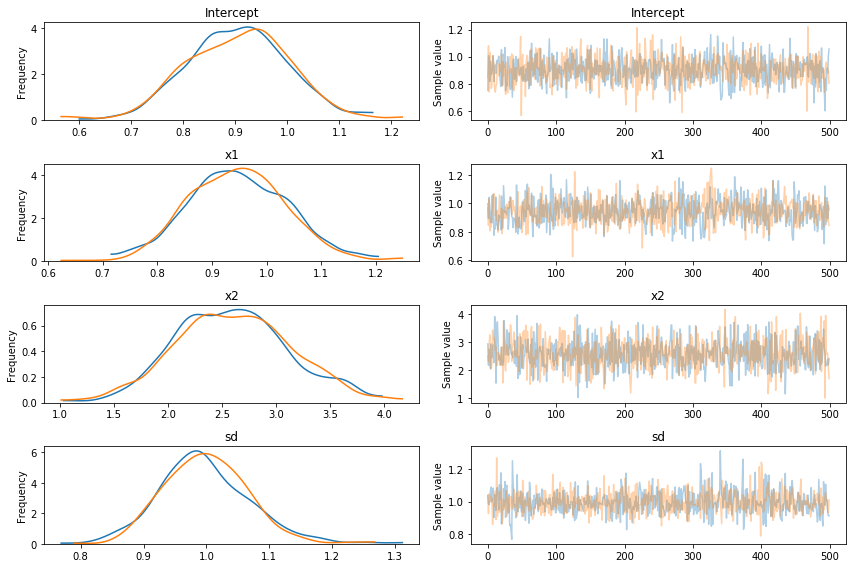

In [20]:
pm.traceplot(trace)